# Default on Credit Card Payment


The project consists of the following:

1. Introduction

2. Exploring The Data

3. Exploratory Data Analysis (EDA)

   3.1 Describing Features

   3.2 Descriptive Figures

       3.2.1 Correlation

       3.2.2 Covariance

       3.2.3 Distribution Plots 

       3.2.4 Boxplot

       3.2.5 Numerical Variables With Respect To Our Target Feature
       
       3.2.6 Categorical Variables With Respect To Our Target Feature
       
       3.2.7 Analysis On Customers' Demographic Variables With Repect To Target Feature

   3.3 Feature Engineering

       3.3.1 Skewed Features: Log Transform

       3.3.2 Feature Selection

       3.3.3 Normalization Of Numerical Features
       
       3.3.4 Up-sampling Minority Class

 
4. Model Selection

   4.1 Data Preparation: Training and Testing Sets

   4.2 Logistic Regression

       4.2.1 Tuning Parameters

       4.2.2 Confusion Matrix, Precision, Recall
       
   4.3 Random Forest
       
       4.3.1 Tuning Parameters
       
       4.3.2 Feature Importance
       
   4.4 Partial Dependency Plot 
   

5. Actionable Recommendations

# 1. Introduction

In this project, we're trying to solve the problem of increase in customer default rates, which is likely to result in the loss of revenue.

Business problems:

1. Increase in customer default rates - This is bad for Credit One since they approve the customers for loans in the first place.
2. Revenue and customer loss for clients and, eventually, loss of clients for the loan company.

The key questions to investigate:

- How to ensure that customers can/will pay their loans?
- Which customers can we approve with high certainty?

In [1]:
# Importing librairies
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer, fbeta_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [2]:
# Parelle processing
import multiprocessing as mp
print("6: ", mp.cpu_count())

6:  8


# 2. Exploring the Data

In [3]:
# Loading the data
credit = pd.read_csv('default.csv')
credit.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
# Remove unmeaningful column
credit = credit.drop('ID', axis =1)

In [5]:
credit.info()
print()
print(credit.isnull().any()) # Check missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6                     30000 non-null int64
PAY_AMT1                

In [6]:
# Assessing if duplicated records are found in the dataset
print("Number of duplicated records in training set: ", credit.duplicated().sum())

Number of duplicated records in training set:  35


In [7]:
# Removing the duplicated rows from the dataset
credit = credit.drop_duplicates()

## 3. Exploratory Data Analysis (EDA)

In this exploratory data analysis, we'll investigate the relationship between each predictor and how they impact customer default rate. 

### 3.1 Describing the Features

In [8]:
# Looking at the distribution of the target feature
default_rate = credit["default payment next month"].value_counts() / credit.shape[0]
default_rate

0    0.778742
1    0.221258
Name: default payment next month, dtype: float64

As you can see, 78% of the observations are 0, so this is an imbalanced dataset. This might affect the accuracy of machine learning models because it's completely ignoring the minority class in favor of the majority class. 
We'll up-sample the minority class later to handle the imbalanced classes. 

In [9]:
# Extract Descriptive Statistics
credit.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,...,29965.000000,29965.000000,29965.000000,29965.000000,2.996500e+04,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000
mean,167442.005006,1.603738,1.853629,1.551877,35.487969,-0.016753,-0.131854,-0.164392,-0.218922,-0.264509,...,43313.329885,40358.334390,38917.012281,5670.099316,5.927983e+03,5231.688837,4831.617454,4804.897047,5221.498014,0.221258
std,129760.135222,0.489128,0.790411,0.521997,9.219459,1.123492,1.196322,1.195878,1.168175,1.132220,...,64353.514373,60817.130623,59574.147742,16571.849467,2.305346e+04,17616.361124,15674.464538,15286.372298,17786.976864,0.415101
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2360.000000,1787.000000,1262.000000,1000.000000,8.500000e+02,390.000000,300.000000,261.000000,131.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19081.000000,18130.000000,17124.000000,2102.000000,2.010000e+03,1804.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54601.000000,50247.000000,49252.000000,5008.000000,5.000000e+03,4512.000000,4016.000000,4042.000000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


The demographic variables do not seem to be very skewed as we can see the mean the median are roughly similar, but bill amount and payment amount variables can have a very wide range. 

Also, education is slightly skewed because very few observations fall into 'others'categories, which doesn't provide any meaningful insights for us, so below we'll shorten the range of education by combining the levels.  

In [10]:
# Check the distribution of education feature. 0,4,5,6 = others
valCount = credit['EDUCATION'].value_counts()
valCount

2    14019
1    10563
3     4915
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [11]:
# Combine all the levels that represent others 
need = credit['EDUCATION'].value_counts().index[:3]
credit['EDUCATION'] = np.where(credit['EDUCATION'].isin(need), credit['EDUCATION'], 0)
valCount = credit['EDUCATION'].value_counts()
print (valCount)

2    14019
1    10563
3     4915
0      468
Name: EDUCATION, dtype: int64


## 3.2 Descriptive Figures

### 3.2.1 Correlation

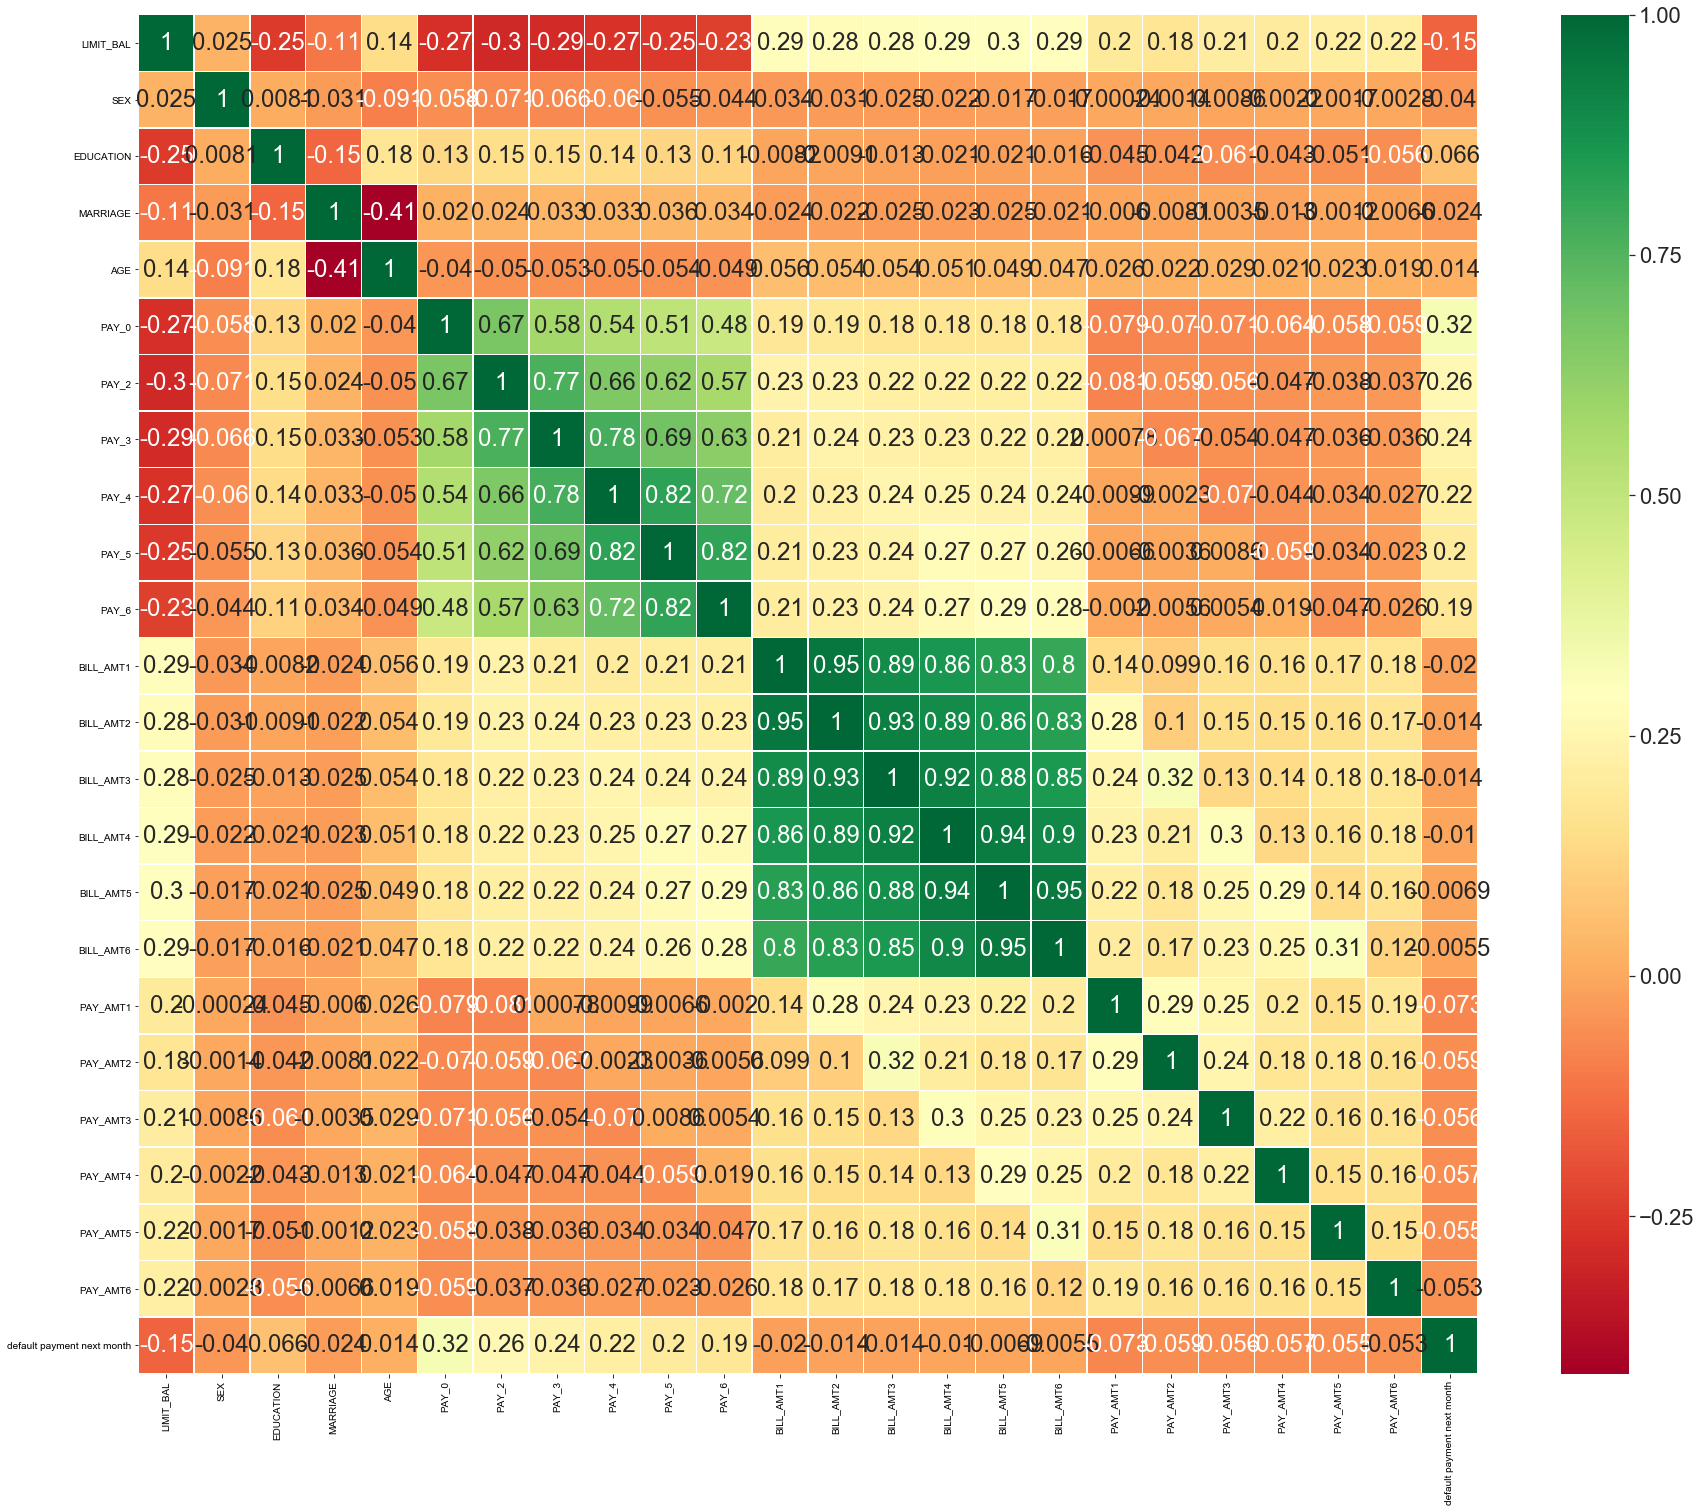

In [12]:
# Create heatmap 
corrMat = credit.corr()
top_corr_features = corrMat.index
fig, ax = plt.subplots(figsize=(30,25))  
sns.set(font_scale=2)
g1=sns.heatmap(credit[top_corr_features].corr(),annot=True,cmap="RdYlGn",linewidths=.5, ax=ax)

In this heatmap, green indicates that the features are highly correlated, and red indicates that they are not correlated. We can see that the most relavant features are payment history, followed by payment amount. 

In [13]:
# Find highly correlated variables
corr = credit.corr().abs()
corr[corr == 1] = 0
corr_cols = corr.max().sort_values(ascending=False)
display(corr_cols[corr_cols > 0.75])

BILL_AMT1    0.951457
BILL_AMT2    0.951457
BILL_AMT6    0.946170
BILL_AMT5    0.946170
BILL_AMT4    0.940103
BILL_AMT3    0.928287
PAY_5        0.819322
PAY_4        0.819322
PAY_6        0.816387
PAY_3        0.776731
PAY_2        0.765965
dtype: float64

All the bill amount and payment history variables are highly correlated with each other, so we'll have to check covariance between bill amount variables to prevent multicollinearity. Payment history is not numerical so we'll try removing the even numbers in feature selection.  

### 3.2.2 Covariance

In [14]:
# Check covariance
covMatrix = np.cov(credit)
covMatrix

array([[1.70533754e+07, 9.78300760e+07, 7.51412340e+07, ...,
        2.04403049e+07, 5.68178674e+07, 4.48811333e+07],
       [9.78300760e+07, 5.92005884e+08, 4.30495457e+08, ...,
        1.33781723e+08, 3.21504488e+08, 2.13976733e+08],
       [7.51412340e+07, 4.30495457e+08, 3.62022316e+08, ...,
        1.18549338e+08, 3.04781405e+08, 2.64343257e+08],
       ...,
       [2.04403049e+07, 1.33781723e+08, 1.18549338e+08, ...,
        8.50745659e+07, 1.12757064e+08, 9.35082528e+07],
       [5.68178674e+07, 3.21504488e+08, 3.04781405e+08, ...,
        1.12757064e+08, 1.03182158e+09, 3.87177194e+08],
       [4.48811333e+07, 2.13976733e+08, 2.64343257e+08, ...,
        9.35082528e+07, 3.87177194e+08, 3.83180996e+08]])

In [15]:
# Check covariance between variables that are highly-correlated

print(credit['BILL_AMT1'].cov(credit['BILL_AMT2']))

4989564348.368132


In [16]:
print(credit['BILL_AMT3'].cov(credit['BILL_AMT4']))

4124688160.3961635


In [17]:
print(credit['BILL_AMT5'].cov(credit['BILL_AMT6']))

3428095090.348883


The covariance is quite high compared to the mean, indicating they are highly linear related. It might affect model's accuracy since independent variables should be independent of each other. In this case, we'll have to remove bill amount variables.  

### 3.2.3 Distribution Plots

In [18]:
# Functions that we will use later on
def data_info(data):
    return data.info()

def creating_boxplots(size, target, features, data):
    plt.figure(figsize=size)
    for i in range(len(num_features)):
        plt.subplot(5, 3, i+1)
        sns.boxplot(x=target, y=features[i], data=data )
        
def creating_distplot(size, data, features):
    plt.figure(figsize=size)
    for i in range(len(features)):
        plt.subplot(5, 3, i+1)
        sns.distplot(data[features[i]])

In [19]:
num_features = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
cat_features =['SEX','MARRIAGE','EDUCATION','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
target = 'default payment next month'

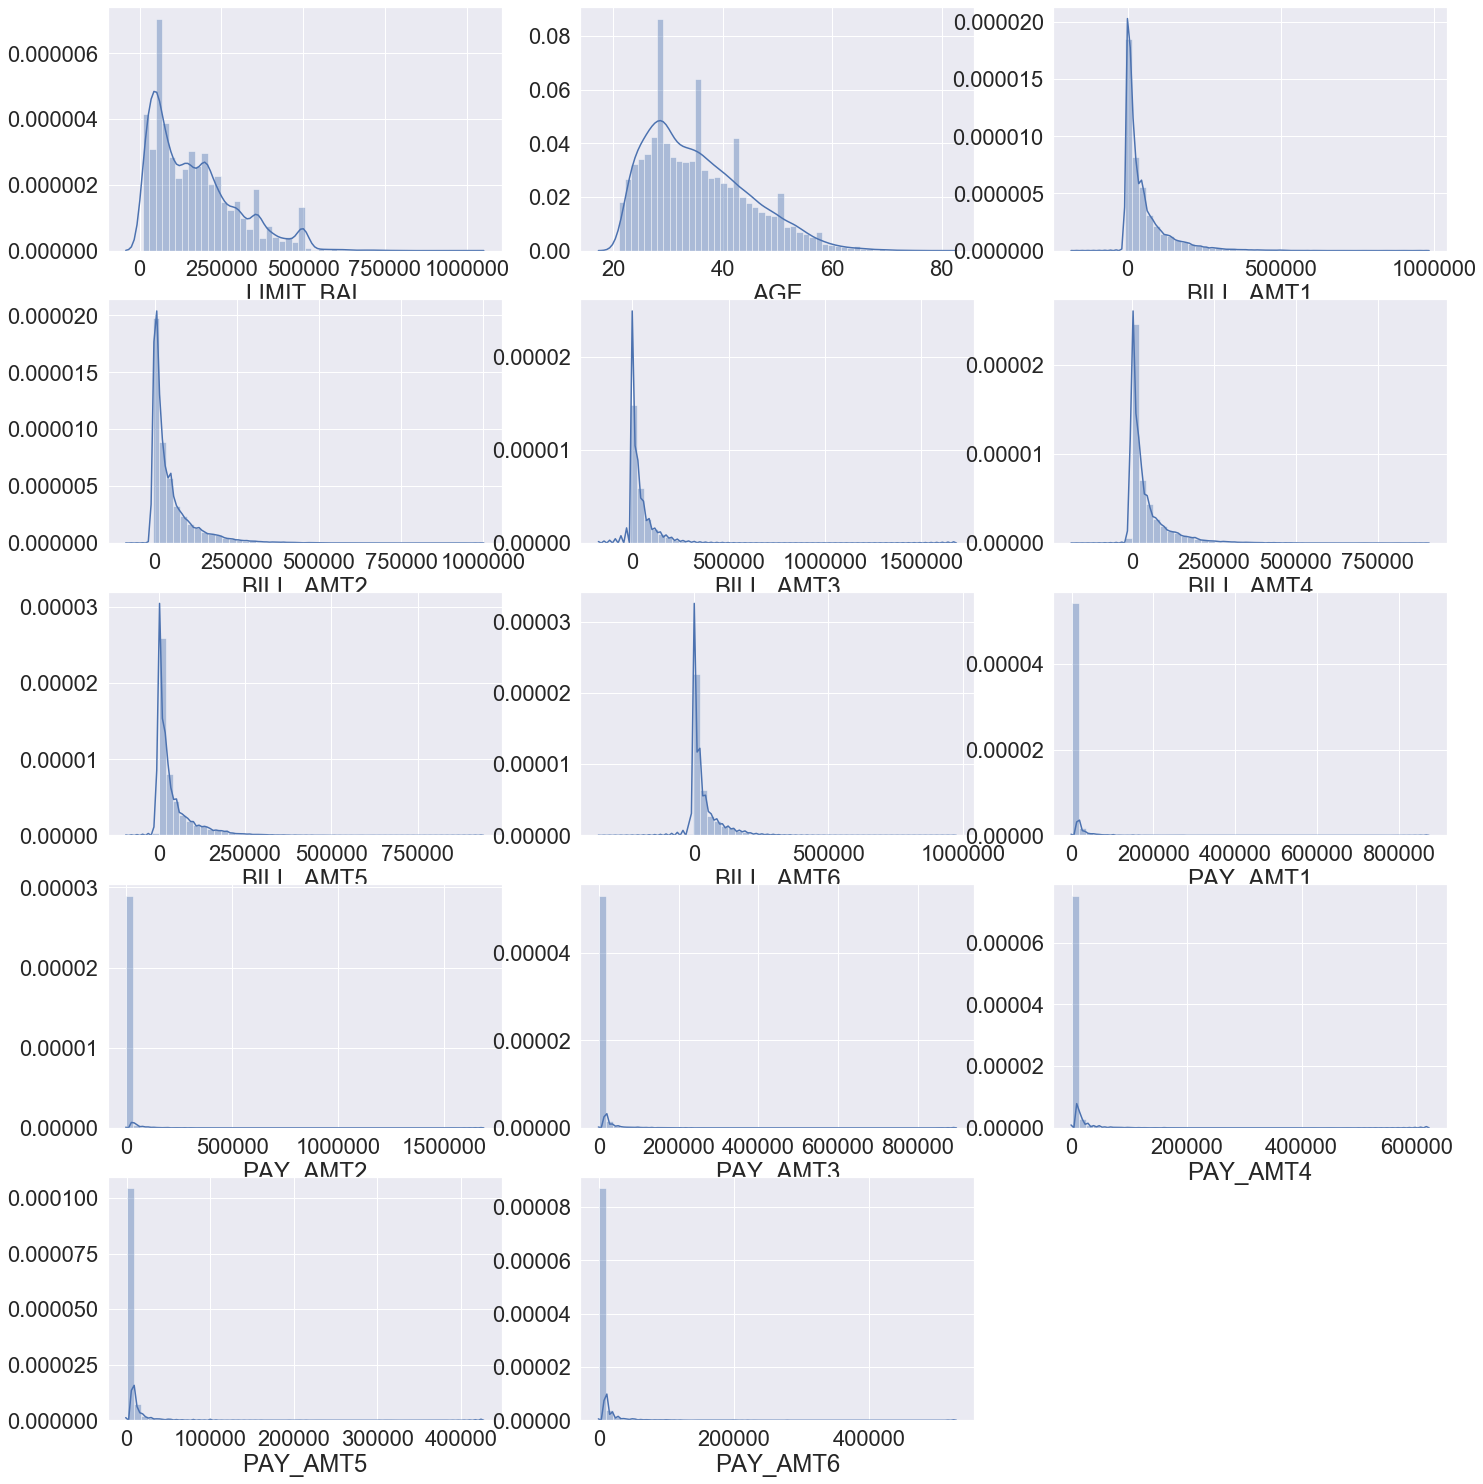

In [20]:
# Creating distribution plots of numerical features
creating_distplot((24,26), credit, num_features)

### 3.2.4 Boxplot

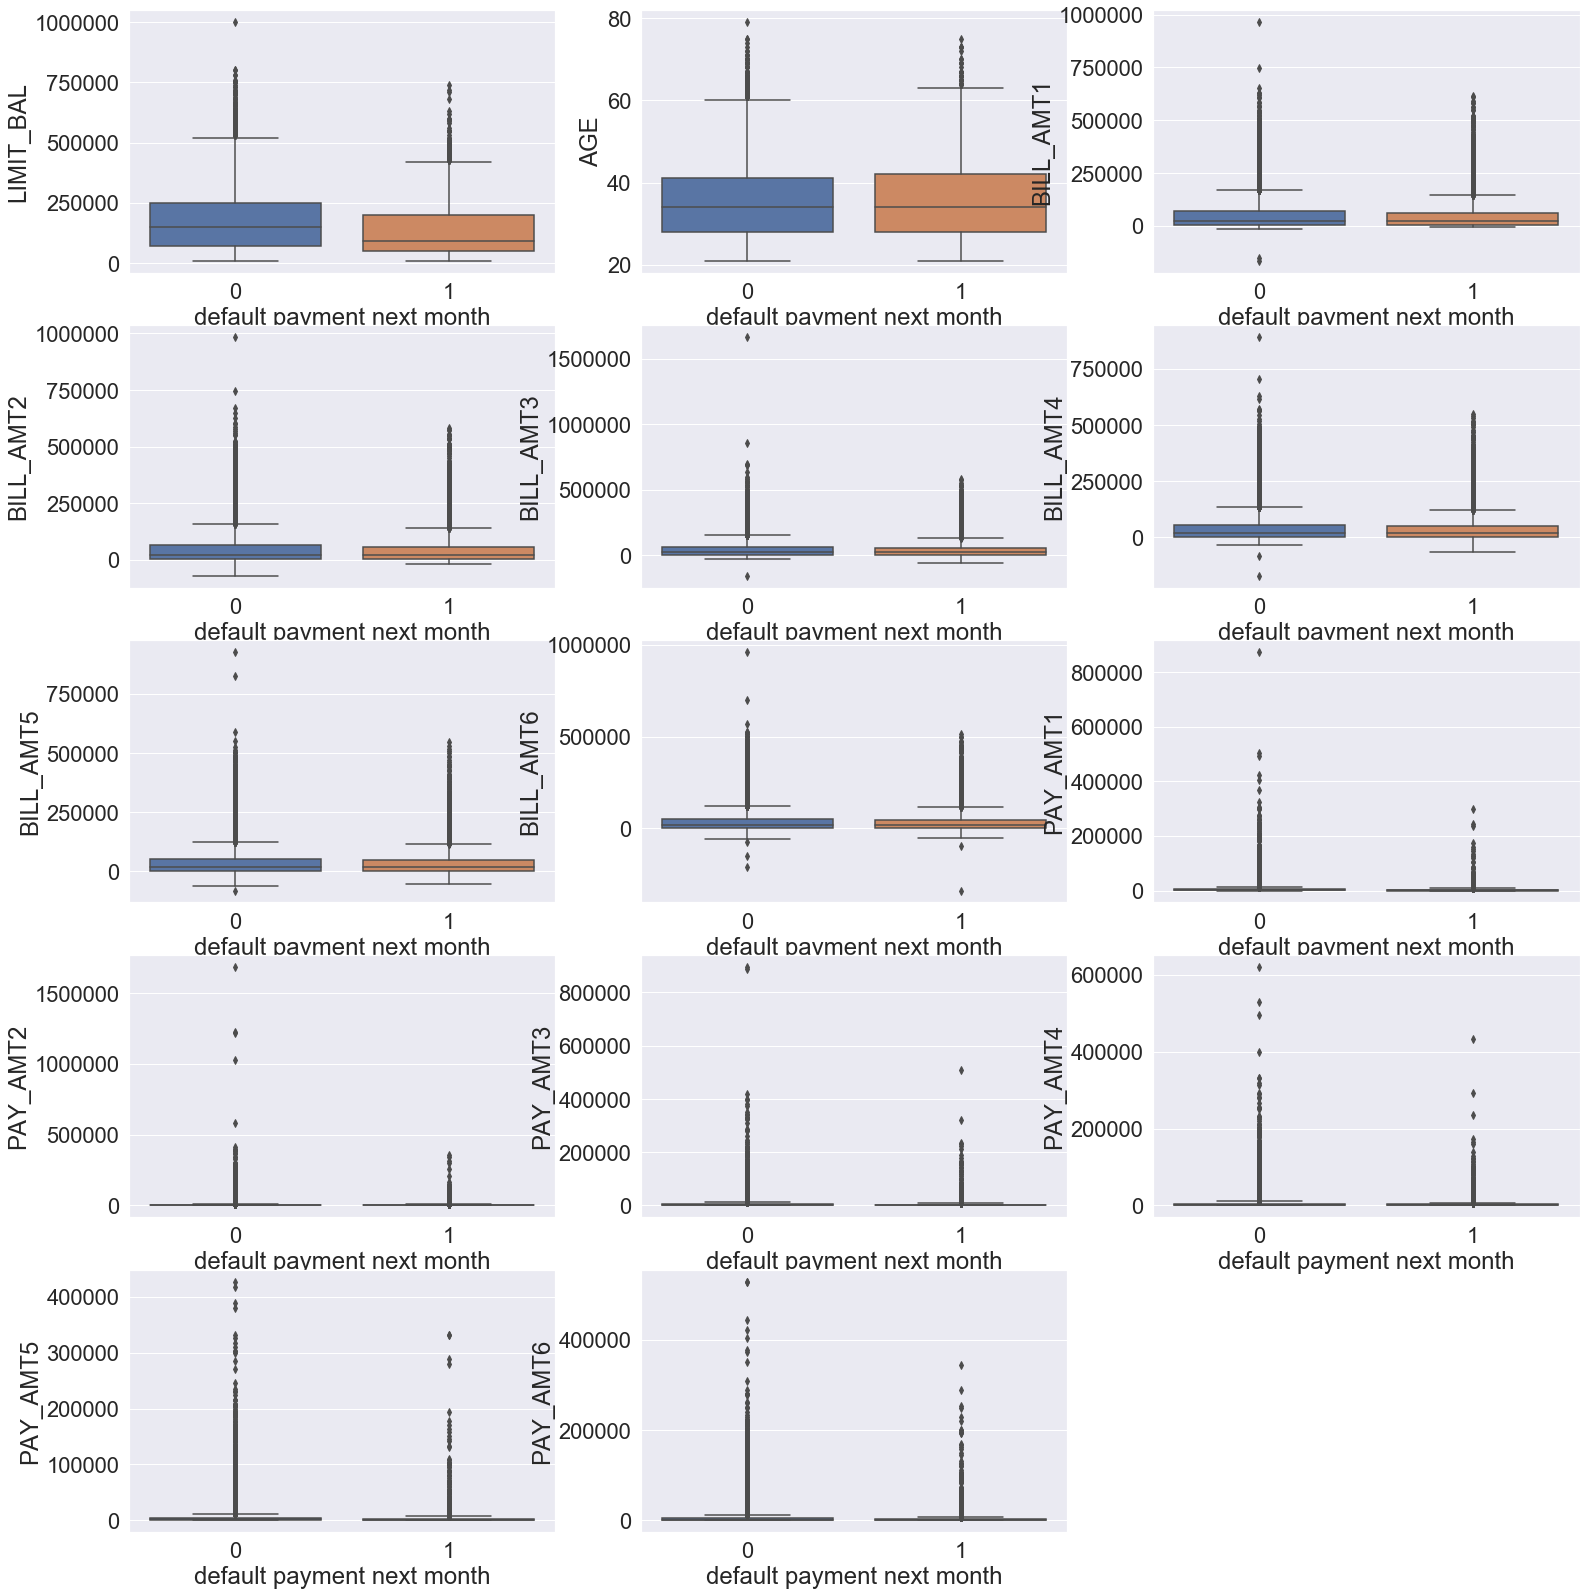

In [21]:
# Generating boxplots of numerical variables with respect to the target feature
creating_boxplots((26,28), target, num_features, credit)

Out of all of numerical features, only credit limit shows noticeable differences between customers who fail on payments and those who don't. It seems to be the only good predictor compared to other numerical features.  

### 3.2.5 Numerical Variables With Regard To Target Variable

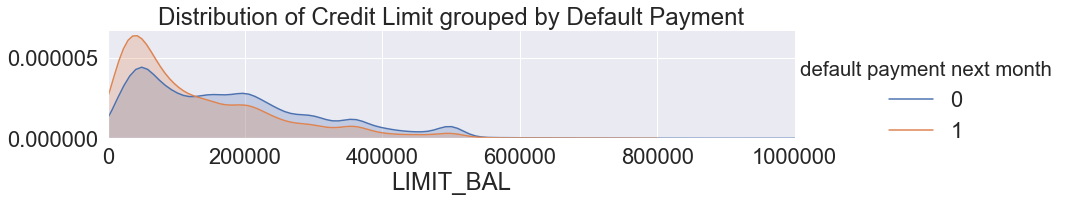

In [22]:
# distribution of credit limit grouped by default payment 
fig = sns.FacetGrid(credit, hue='default payment next month', aspect=4)
fig.map(sns.kdeplot, 'LIMIT_BAL', shade=True)
oldest = credit['LIMIT_BAL'].max()
fig.set(xlim=(0,oldest))
fig.set(title='Distribution of Credit Limit grouped by Default Payment')
fig.add_legend()

When customers' credit limit is under 120000, they are more likely to default on payment, but vice versa when their credit limit is over 120000. 

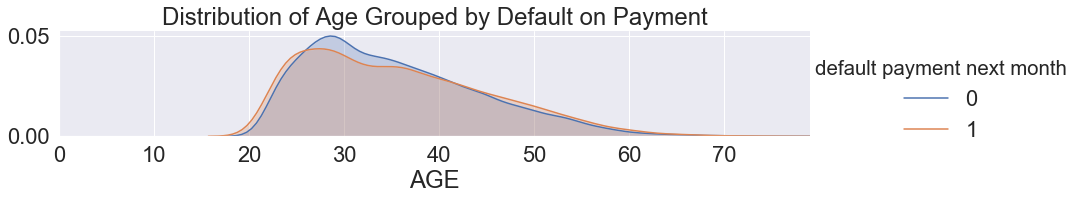

In [23]:
fig = sns.FacetGrid(credit, hue='default payment next month', aspect=4)
fig.map(sns.kdeplot, 'AGE', shade=True)
oldest = credit['AGE'].max()
fig.set(xlim=(0,oldest))
fig.set(title='Distribution of Age Grouped by Default on Payment')
fig.add_legend()

There's no significant difference of age distribution between customers who pay on time and those who fail on payments, so age is not a strong predictor, which matches the result of box plot. We can only say that majority of the customers are in their mid 20's to late 30's.   

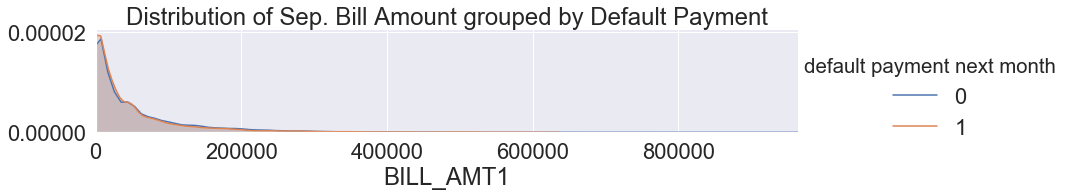

In [24]:
# distribution of Sep. bill amount grouped by default payment 
fig = sns.FacetGrid(credit, hue='default payment next month', aspect=4)
fig.map(sns.kdeplot, 'BILL_AMT1', shade=True)
oldest = credit['BILL_AMT1'].max()
fig.set(xlim=(0,oldest))
fig.set(title='Distribution of Sep. Bill Amount grouped by Default Payment')
fig.add_legend()

We can see that the distributions of bill amount do not differ much for customers who fail on payments and those who pay on time. It doesn't seem to be a good predictor.

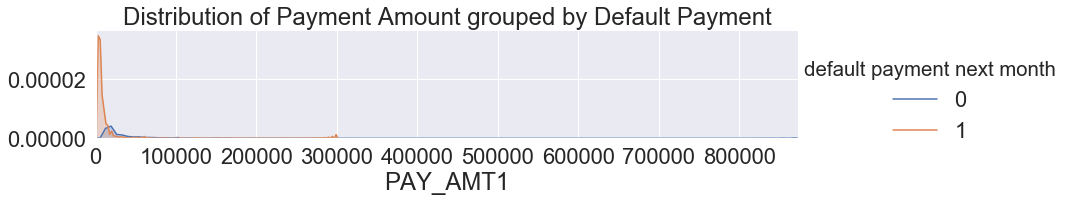

In [25]:
# distribution of Sep.payment amount grouped by default payment 
fig = sns.FacetGrid(credit, hue='default payment next month', aspect=4)
fig.map(sns.kdeplot, 'PAY_AMT1', shade=True)
oldest = credit['PAY_AMT1'].max()
fig.set(xlim=(0,oldest))
fig.set(title='Distribution of Payment Amount grouped by Default Payment')
fig.add_legend()

Payment amount of customers who fail on payments has a distribution significantly skewed to the left, indicating customers who fail on payment tend to make very small amount of payment compared to their bill amount.  

### 3.2.6 Categorical Variables With Respect To Target Feature

C:\Users\Noxar\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


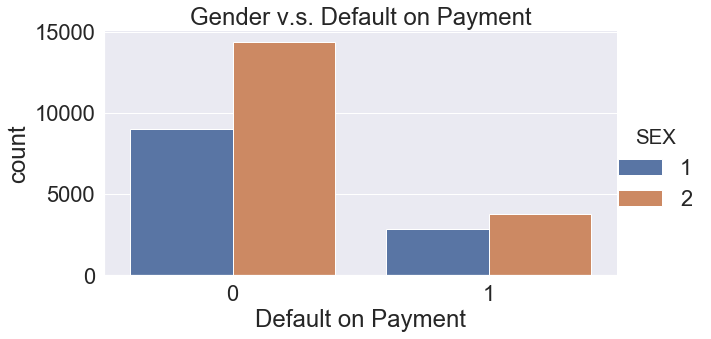

In [26]:
# Sex and default payment (1 = male; 2 = female)
g = sns.factorplot('default payment next month', data=credit, hue='SEX', kind='count', aspect=1.75)
g.set_xlabels('Default on Payment')
g.set(title="Gender v.s. Default on Payment")

Among the customers who fail to pay on time, female is slightly more than male. Gender might be a good predictor but we need to look at it with other demographic predictors.

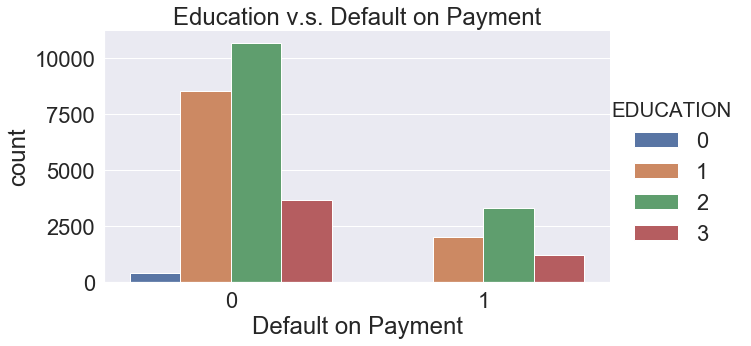

In [27]:
# Education and default payment (1 = graduate school; 2 = university; 3 = high school; 0 = others) 
g = sns.factorplot('default payment next month', data=credit, hue='EDUCATION', kind='count', aspect=1.75)
g.set_xlabels('Default on Payment')
g.set(title="Education v.s. Default on Payment")

Among the customers who fail to pay on time, most of them have a college degree, followed by a graduate degree and a high school diploma, which is consistent with the composition of customers' education level. It indicates that education is not a strong predictor of default payment.

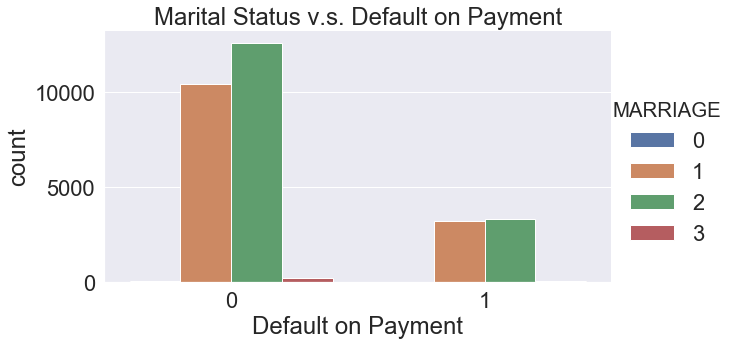

In [28]:
# clients' marital status and default payment (1 = married; 2 = single; 3 = divorce; 0=others). 
g = sns.factorplot('default payment next month', data=credit, hue='MARRIAGE', kind='count', aspect=1.75)
g.set_xlabels('Default on Payment')
g.set(title="Marital Status v.s. Default on Payment")

Among the cutomers who fail on payments, about half are married and half ar single; marrital status alone is not enough to predict default payment.

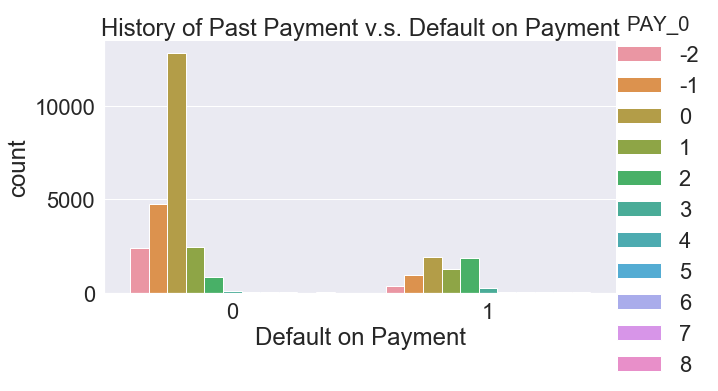

In [29]:
# Sep.payment history and default payment next month (-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay 1 month)
g = sns.factorplot('default payment next month', data=credit, hue='PAY_0', kind='count', aspect=1.75)
g.set_xlabels('Default on Payment')
g.set(title="History of Past Payment v.s. Default on Payment")

We can see that there's a significant amount of customers who make their payment on time use their revolving credits; whereas customers who fail to make payment are likely to use revolving credits or late for 1 or 2 months.  

### 3.2.7 Analysis On Customers' Demographic Variables With Repect To Target Feature

We'll look at the relavant demographic variables: gender, marrital status, and education and their relations with the target feature.  

#### Default on payment grouped by gender and merital status

In [30]:
credit.pivot_table('default payment next month', 'SEX', 'MARRIAGE', aggfunc=np.sum, margins=True)

MARRIAGE,0,1,2,3,All
SEX,,,,,
1,2,1343,1484,40,2869
2,3,1858,1856,44,3761
All,5,3201,3340,84,6630


Single women are most likely to fail payments, followed by married women and married men. Divorced men are women are least likely to fail on payments. Gender has a significant impact on the chances of defaulting payments for single and married people, but not for divorced people.

#### Default on payment grouped by gender and education

In [31]:
credit.pivot_table('default payment next month', 'SEX', 'EDUCATION', aggfunc=np.sum, margins=True)

EDUCATION,0,1,2,3,All
SEX,,,,,
1,14,904,1406,545,2869
2,19,1128,1922,692,3761
All,33,2032,3328,1237,6630


Women with a college degree are most likely to default on a payment, followed by men with a college degree. Men with a high scholl diploma are least likely to fail on payment, followed by women with a high school diploma. Gender has a significant impact on people with a college degree, but not so much on the others.

#### Default on payment grouped by marital status and education 

In [32]:
credit.pivot_table('default payment next month', 'MARRIAGE', 'EDUCATION', aggfunc=np.sum, margins=True)

EDUCATION,0,1,2,3,All
MARRIAGE,,,,,
0,NaN,0.0,1.0,4.0,5
1,17.0,765.0,1665.0,754.0,3201
2,16.0,1254.0,1618.0,452.0,3340
3,0.0,13.0,44.0,27.0,84
All,33.0,2032.0,3328.0,1237.0,6630


Single people with a college degree are most likely to default on payments, followed by married people with a college degree and married people wuth a graduate degree. Marital status only has significant impact on the chances of defaulting on payments when clients have a graduate degree.

## 3.3 Feature Engineering

### 3.3.1 Skewed Features: Log Transform

In [34]:
credit["log_age"] = np.log(credit["AGE"])
credit["log_limit"] = np.log(credit["LIMIT_BAL"])

In EDA we see that some features have skewed distributions. We'll apply logarithmic transformation to reduce the range of distributions to help improve model performance.

### 3.3.2 Feature Selection

In [35]:
df = credit.loc[:,["SEX","EDUCATION","MARRIAGE","log_age","log_limit","PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6","default payment next month"]]

In the feature selection process, we'll remove the bill amount variables because there seem to be a linear relationship between them, which will affect the model's prediction, also they do not appear to be good predictors as shown in the exploratory data analysis. 

### 3.3.3 Normalize Numerical Features

In [36]:
# Defining target and numerical variables 
numerical_vars = ["log_age","log_limit","PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6"]
target = "default payment next month"

# Initialize a scaler, then apply it to the features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # default=(0, 1)

# Applying the MinMax transformation of the numerical variables
data = pd.DataFrame(data = df)
data[numerical_vars] = scaler.fit_transform(data[numerical_vars])

# Show an example of a record with scaling applied
data.head()

,SEX,EDUCATION,MARRIAGE,log_age,log_limit,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,2,2,1,0.100784,0.150515,0.4,0.4,0.1,0.1,0.0,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000,1
1,2,2,2,0.161197,0.539591,0.1,0.4,0.2,0.2,0.2,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783,1
2,2,2,2,0.363672,0.477121,0.2,0.2,0.2,0.2,0.2,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458,0
3,2,2,1,0.427492,0.349485,0.2,0.2,0.2,0.2,0.2,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892,0
4,1,2,1,0.753649,0.349485,0.1,0.2,0.1,0.2,0.2,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284,0


### 3.3.4 Up-sample Minority Class

In the exploratory data analysis we fould that the target feature has imbalanced classes, so we'll use up-sampling to randomly duplicate observations from the minority class in order to reinforce its signal.

In [37]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = data[data[target]==0]
df_minority = data[data[target]==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=23335,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled[target].value_counts()

1    23335
0    23335
Name: default payment next month, dtype: int64

# 4. Model Selection

In this section, we will test different algorithms and tune the model's parameters to choose the best fit of this dataset. In this case, false negatives are crucial because customers who are predicted to pay on time but fail to pay can cause huge loss for the company, so we'll use confision matrix to minimize the number of false negatives.


## 4.1 Data Preparation: Training and Testing Sets

In [38]:
# Creating training and test set 
X, y = data.drop([target],1).values, data[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size=0.3,
                                                  random_state=42,
                                                  stratify=y)

In [39]:
# sanity check
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(20975, 16)
(20975,)
(8990, 16)
(8990,)


## 4.2 Logistic Regression

### 4.2.1 Tuning Parameters

In [40]:
from sklearn.linear_model import LogisticRegression


parameters = {"C": [0.001, 0.01, 0.1, 1, 10 , 100, 1000]}

model = LogisticRegression(random_state=42, penalty="l2")

# fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Grid Search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(model, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
best_predictions = best_clf.predict(X_test)

# Report the scores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_clf)

C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F


Optimized Model
------
Final accuracy score on the testing data: 0.8107
Final F-score on the testing data: 0.5083
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


It shows the value of 10 for the C parameter used in the L2-Regularization produces the best result. We will now perform another search with a much narrower search in order to identify the best parameter.

In [41]:
parameters = {"C": [5,6,7,8,8.5,9,9.1,9.4,9.6,9.8,10,10.2,10.5,10.7,11,11.5,12,13,14,15]}

model = LogisticRegression(random_state=42, penalty="l2")

# fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Grid Search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(model, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
best_predictions = best_clf.predict(X_train)

# Report the scores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_train, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_train, best_predictions, beta = 0.5)))
print(best_clf)

C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to


Optimized Model
------
Final accuracy score on the testing data: 0.8086
Final F-score on the testing data: 0.5007
LogisticRegression(C=11.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [43]:
parameters = {"C": [11.2,11.3,11.4,11.6,11.7,11.8]}

model = LogisticRegression(random_state=42, penalty="l2")

# fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Grid Search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(model, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
best_predictions = best_clf.predict(X_train)

# Report the scores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_train, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_train, best_predictions, beta = 0.5)))
print(best_clf)

C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to


Optimized Model
------
Final accuracy score on the testing data: 0.8086
Final F-score on the testing data: 0.5010
LogisticRegression(C=11.8, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Our best result on the traning set is with C=11.8 and with L2-Regularization:
Accoracy of 80.86%
F-score of 50.1%

Next we'll use confision matrix, precision and recall as our matrics to evaluate the model.  

### 4.2.2 Confusion Matrix, Precision, Recall

In [69]:
def metrics(y, y_pred):
    confmat = confusion_matrix(y, y_pred)
    TP = confmat[0,0]
    FN = confmat[0,1]
    FP = confmat[1,0]
    TN = confmat[1,1]
 
    # Print the confusion matrix
    print("Confusion matrix:\n", confmat)
    print()
    
    # Print the Accuracy Score
    print("Accuracy:", round(accuracy_score(y, y_pred),2))

    # Print the Sensitivity/recall/true positive rate
    print("Recall:", round(recall_score(y, y_pred),2))

    # Precision/positive predictive value
    print("Precision:", round(precision_score(y, y_pred),2))

In [63]:
# Confusion matrix
print(metrics(y_train, best_predictions))

Confusion matrix:
 [[15884   450]
 [ 3564  1077]]

Accuracy: 0.81
Recall: 0.23
Precision: 0.71
None


Since we're trying to minimize false negatives, recall score, in this case, is more important than precision. Even though false positives will result in the company turning away potential good customers, but failing to predict customers who will default on payments will result in greater loss for the company.  

Text(0, 0.5, 'Frequency')

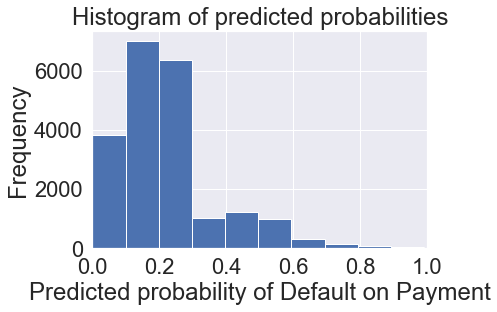

In [45]:
y_pred_prob = best_clf.predict_proba(X_train)[:,1]

plt.rcParams["font.size"]= 14
plt.hist(y_pred_prob, bins=10)
plt.xlim(0, 1)
plt.title("Histogram of predicted probabilities")
plt.xlabel("Predicted probability of Default on Payment")
plt.ylabel("Frequency")

It seems the probability of defaulting on payment is heavily centered on the lower end and very few are higher than 0.5. We'll lower the threshold to 0.2 to decrease the chances of false negatives.

In [64]:
# Lower threshold to 0.2
y_pred_prob = best_clf.predict_proba(X_train)[:,1]
y_pred_class = np.where(y_pred_prob<0.2,0,1)
metrics(y_train, y_pred_class)

Confusion matrix:
 [[9637 6697]
 [1360 3281]]

Accuracy: 0.62
Recall: 0.71
Precision: 0.33


Recall score increased by 48% if we set the threshold to 0.2, and number of false negatives decreased by 2200. 

In [65]:
# Apply the optimal model on testing set
test_predictions = best_clf.predict(X_test)
metrics(y_test, test_predictions)

Confusion matrix:
 [[6830  171]
 [1531  458]]

Accuracy: 0.81
Recall: 0.23
Precision: 0.73


In [66]:
# Predicting probability on testing set
test_predictions_prob = best_clf.predict_proba(X_test)[:,1]
y_testpred_class = np.where(test_predictions_prob<0.2, 0, 1)
metrics(y_test, y_testpred_class)

Confusion matrix:
 [[4163 2838]
 [ 570 1419]]

Accuracy: 0.62
Recall: 0.71
Precision: 0.33


Using logistic regression to predicting probability helped us better understand the problem and by minimizing the false negatives, we will be able to decrease the loss in revenue due to customers defaulting on payment.   

## 4.3 Random Forest

### 4.3.1 Tuning Parameters

Below we'll test four parameters: max depth, numberof trees, max features and min number of samples in newly created leaves, and use AUC score to find the sweet spot where the model can achieve the best result without overfitting.   

### Max Depth

C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


1 depth
AUC Train:  0.8546651275819592
AUC Test:  0.6136327648086471
 


C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2 depth
AUC Train:  0.8035451147238902
AUC Test:  0.5854716653636136
 
3 depth


C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


AUC Train:  0.9199045527922861
AUC Test:  0.631513389346304
 
4 depth


C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


AUC Train:  0.8838767566628613
AUC Test:  0.6151291394197871
 
5 depth


C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


AUC Train:  0.9462833951054119
AUC Test:  0.6411636303626523
 
10 depth


C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


AUC Train:  0.9545869491706035
AUC Test:  0.6397960888873953
 


C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


20 depth
AUC Train:  0.9827329185434617
AUC Test:  0.6470890210398013
 
50 depth
AUC Train:  0.9969846025835337
AUC Test:  0.6529479125620853
 
70 depth
AUC Train:  0.9983080384012398
AUC Test:  0.6539877338502745
 
75 depth
AUC Train:  0.9985235092049459
AUC Test:  0.6548161366590667
 
80 depth
AUC Train:  0.998631244606799
AUC Test:  0.6535563870104314
 
85 depth
AUC Train:  0.9986618556022686
AUC Test:  0.656541524018439
 
90 depth
AUC Train:  0.9986618556022686
AUC Test:  0.6547790091611563
 
95 depth
AUC Train:  0.998738980008652
AUC Test:  0.6563244322850094
 
100 depth
AUC Train:  0.998738980008652
AUC Test:  0.6553874836095024
 


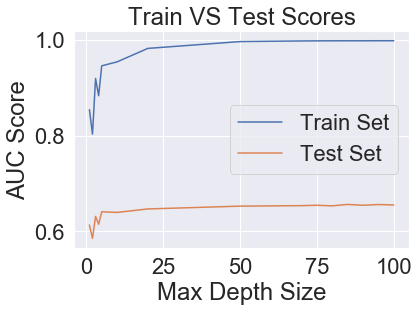

In [47]:
from sklearn.metrics import roc_auc_score

results  =  []
results2 = []
max_depth_size  = [1,2,3,4,5,10,20,50,70,75,80,85,90,95,100]

for depth in max_depth_size:
    model = RandomForestClassifier(depth, oob_score=True, n_jobs=-1, random_state=42)
    #model.fit(X, y)
    model.fit(X_train, y_train)
    print(depth, 'depth')
    pred = model.predict(X_train)
    pred2 = model.predict(X_test)
    roc1 = roc_auc_score(y_train, pred)
    roc2 = roc_auc_score(y_test, pred2)
    print('AUC Train: ', roc1)
    print('AUC Test: ', roc2)
    results.append(roc1)
    results2.append(roc2)
    print (" ")

plt.plot(max_depth_size, results, label='Train Set')
plt.plot(max_depth_size, results2, label='Test Set')
plt.xlabel('Max Depth Size')
plt.ylabel('AUC Score')
plt.title('Train VS Test Scores')
plt.legend(loc="right")
plt.show()

### n_estimators

1 trees
AUC Train:  0.8195644468899822
AUC Test:  0.6128303943363976
 
2 trees
AUC Train:  0.778555705561086
AUC Test:  0.5878395666955285
 
3 trees
AUC Train:  0.8682874031209153
AUC Test:  0.6228464884245152
 
4 trees
AUC Train:  0.8448252986098982
AUC Test:  0.6065331541734073
 
5 trees
AUC Train:  0.8896686788795635
AUC Test:  0.6269402798091976
 
15 trees
AUC Train:  0.9186808780834955
AUC Test:  0.6344134275438207
 
25 trees
AUC Train:  0.9250042681265177
AUC Test:  0.6349048462444028
 
40 trees
AUC Train:  0.9269693410136657
AUC Test:  0.6348535356114106
 
50 trees
AUC Train:  0.9273207705438563
AUC Test:  0.6380415812177662
 
60 trees
AUC Train:  0.9276586853294406
AUC Test:  0.6389728566392405
 
70 trees
AUC Train:  0.9282279733341755
AUC Test:  0.6359562653873552
 
80 trees
AUC Train:  0.9278717684623086
AUC Test:  0.6361047753789968
 
100 trees
AUC Train:  0.9275938818322442
AUC Test:  0.6376473618758335
 


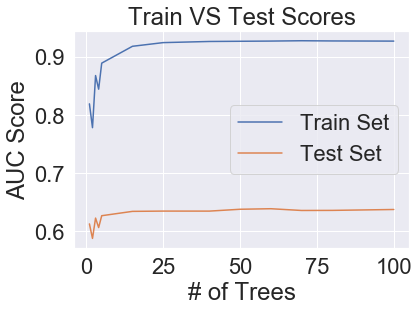

In [49]:
from sklearn.metrics import roc_auc_score

results = []
results2 = []
n_estimator_options = [1, 2, 3, 4, 5, 15, 25, 40, 50, 60, 70, 80, 100]

for trees in n_estimator_options:
    model = RandomForestClassifier(trees, oob_score=True, n_jobs=-1, random_state=42)
    
    #model.fit(X, y)
    model.fit(X_train, y_train)
    print(trees, 'trees')
    pred = model.predict(X_train)
    pred2 = model.predict(X_test)
    roc1 = roc_auc_score(y_train, pred)
    roc2 = roc_auc_score(y_test, pred2)
    print('AUC Train: ', roc1)
    print('AUC Test: ', roc2)
    results.append(roc1)
    results2.append(roc2)
    print (" ")

plt.plot(n_estimator_options, results, label='Train Set')
plt.plot(n_estimator_options, results2, label='Test Set')
plt.xlabel('# of Trees')
plt.ylabel('AUC Score')
plt.title('Train VS Test Scores')
plt.legend(loc="right")
plt.show()

### Max Features

C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


auto option
AUC:  0.7835041716328963
 


C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarn

None option
AUC:  0.7752562574493445
 
sqrt option
AUC:  0.7835041716328963
 


C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


log2 option
AUC:  0.7835041716328963
 
0.7 option
AUC:  0.7809296781883194
 
0.2 option
AUC:  0.782026221692491
 


C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarn

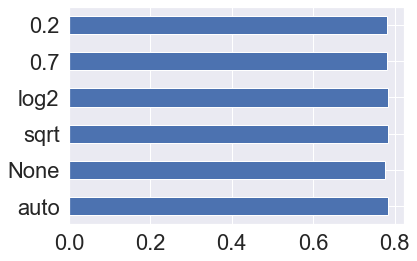

In [49]:
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.7, 0.2]

for max_features in max_features_options:
    model = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model.fit(X_train, y_train)
    print(max_features, "option")
    auc = model.oob_score_
    print('AUC: ', auc)
    results.append(auc)
    print (" ")
    
pd.Series(results, max_features_options).plot(kind='barh')

### Min Sample Leafs

C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


1 min samples
AUC Train:  0.8546651275819592
AUC Test:  0.6136327648086471
 
2 min samples
AUC Train:  0.8035451147238902
AUC Test:  0.5854716653636136
 
3 min samples


C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


AUC Train:  0.9199045527922861
AUC Test:  0.631513389346304
 
4 min samples


C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


AUC Train:  0.8838767566628613
AUC Test:  0.6151291394197871
 
5 min samples


C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


AUC Train:  0.9462833951054119
AUC Test:  0.6411636303626523
 
6 min samples


C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


AUC Train:  0.9229028077874585
AUC Test:  0.6231019643893435
 
7 min samples


C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


AUC Train:  0.9603394748184757
AUC Test:  0.6494937985229288
 
8 min samples


C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


AUC Train:  0.9423687230211334
AUC Test:  0.6339057431212333
 
9 min samples


C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


AUC Train:  0.9700149832281294
AUC Test:  0.6504480183072318
 
10 min samples


C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


AUC Train:  0.9545869491706035
AUC Test:  0.6397960888873953
 


C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


20 min samples
AUC Train:  0.9827329185434617
AUC Test:  0.6470890210398013
 


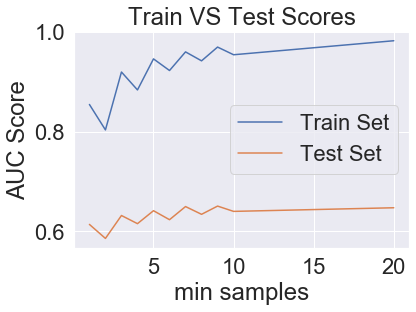

In [50]:
results = []
results2 = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,20]

for min_samples in min_samples_leaf_options:
    model = RandomForestClassifier(min_samples, oob_score=True, n_jobs=-1, random_state=42)
    
    #model.fit(X, y)
    model.fit(X_train, y_train)
    print(min_samples, 'min samples')
    pred = model.predict(X_train)
    pred2 = model.predict(X_test)
    roc1 = roc_auc_score(y_train, pred)
    roc2 = roc_auc_score(y_test, pred2)
    print('AUC Train: ', roc1)
    print('AUC Test: ', roc2)
    results.append(roc1)
    results2.append(roc2)
    print (" ")

plt.plot(min_samples_leaf_options, results, label='Train Set')
plt.plot(min_samples_leaf_options, results2, label='Test Set')
plt.xlabel('min samples')
plt.ylabel('AUC Score')
plt.title('Train VS Test Scores')
plt.legend(loc="right")
plt.show()

In [51]:
model1 = RandomForestClassifier(random_state = 42,
                                  n_estimators = 60,
                                  max_depth = 85, 
                                  max_features = "log2",  min_samples_leaf = 7) 
rf1 = model1.fit(X_train, y_train) 
print(cross_val_score(rf1, X_train, y_train))
rf1.score(X_train,y_train)

C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.82208238 0.81779176 0.815334  ]


0.8567342073897497

In [52]:
model2 = RandomForestClassifier(random_state = 42,
                                  n_estimators = 60,
                                  max_depth = 95, 
                                  max_features = "log2",  min_samples_leaf = 3) 
rf2 = model2.fit(X_train, y_train) 
print(cross_val_score(rf2, X_train, y_train))
rf2.score(X_train,y_train)

C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.82022311 0.81378719 0.81147189]


0.9063170441001192

In [53]:
model3 = RandomForestClassifier(random_state = 42,
                                  n_estimators = 65,
                                  max_depth = 95, 
                                  max_features = "log2",  min_samples_leaf = 9) 
rf3 = model3.fit(X_train, y_train) 
print(cross_val_score(rf3, X_train, y_train))
rf3.score(X_train,y_train)

C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.82079519 0.81822082 0.81418967]


0.8481048867699642

Model 2 seems to be the best one out of the three, so we'll use it on the testing set and compare it to the logistic regression model we built.

In [55]:
# Apply the optimal model on testing set
pred2 = rf2.predict(X_test)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf2.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.82


In [57]:
# Confusion matrix
confmat = confusion_matrix(y_test, pred2)
print("The Confusion matrix:\n", confmat)
print("Precision Score:", round(precision_score(y_test, pred2), 2))
print("Recall Score:", round(recall_score(y_test, pred2), 2))

The Confusion matrix:
 [[6604  397]
 [1239  750]]
Precision Score: 0.65
Recall Score: 0.38


The recall score of random forest model is 15% higher than logistic regression model; accuracy is slightly higher by 1%. For hard predictions, random forest seems to be the better fit. But the predicted probability using logistic regression allows us to find the threshold that can effectively moinimize false negatives based on the distribution of probability.    

### 4.3.2 Feature Importance

SEX          0.015786
EDUCATION    0.021882
MARRIAGE     0.015678
log_age      0.080813
log_limit    0.073907
PAY_0        0.159435
PAY_2        0.068093
PAY_3        0.046087
PAY_4        0.035869
PAY_5        0.028235
PAY_AMT1     0.084064
PAY_AMT2     0.076738
PAY_AMT3     0.072755
PAY_AMT4     0.074151
PAY_AMT5     0.071544
PAY_AMT6     0.074960
dtype: float64


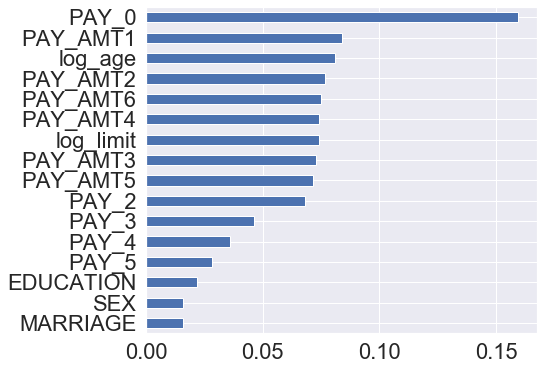

In [58]:
# Extracting feature importances from our model
feature_importances = pd.Series(rf2.feature_importances_, index=data.drop([target],1).columns)
print(feature_importances)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(7,6))

Payment history, payment amount, age and credit limit seem to be the most significant factors in determining the chances of defaulting on payment, whereas gender and merital status don't have a significant impact.   

# 4.4 Partial Dependency Plot

PDP explains how target feature is related with important numerical features and the directional relationship between the features.

C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_partial_dependence is deprecated; The function ensemble.plot_partial_dependence has been deprecated in favour of sklearn.inspection.plot_partial_dependence in  0.21 and will be removed in 0.23.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Noxar\Anaconda

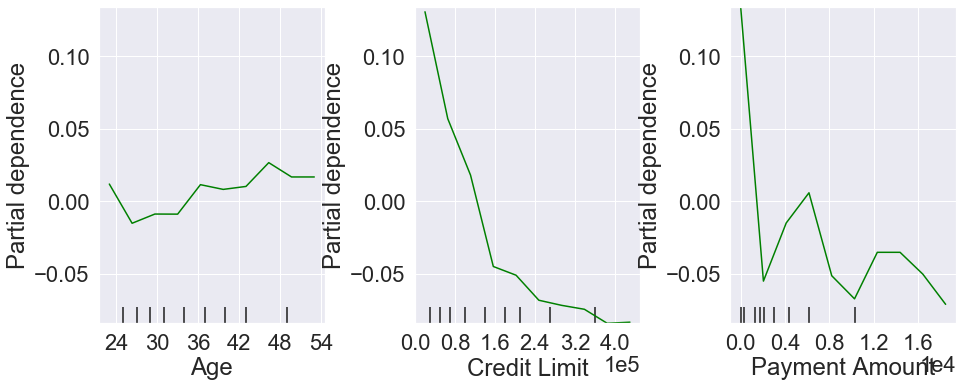

In [93]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.preprocessing import Imputer

def get_data():
    cols = ['AGE', 'LIMIT_BAL', 'PAY_AMT1']
    y = credit['default payment next month']
    X = credit[cols]
    my_imputer = Imputer()
    imputed_X = my_imputer.fit_transform(X)
    return imputed_X, y

X, y = get_data()
my_model = GradientBoostingRegressor()
my_model.fit(X, y)
my_plots = plot_partial_dependence(my_model,       
                                   features=[0, 1, 2],
                                   X=X,           
                                   feature_names=['Age', 'Credit Limit', 'Payment Amount'],
                                   grid_resolution=10, figsize=(14, 8))


- Age: customers have higher chances of defaulting onpayment if they are over 35.
- Credit limit: the lower the credit limit, the more likely the customer will default on payment. 
- Payment amount: customers that pay only a small amount of monthly payment are more likely to default on payment. 

# 5. Actionable Recommendations

According to our model and the exploratory data analysis, we can identify the customers with high risk of defaulting on payment based on the below attributes:
1. Payment amount
2. Credit limit
3. Payment history
4. Age
5. Education


Payment history, payment amount and credit limit are the most significant factors in predicting defaulting on payment, but we use the demographic attributes to pre-qualify those customers of low risk. We cannot mitigate with 100% certainty any customer possibly defaulting on a payment. However, there are some steps that we can take to reduce the level of risk.


Customers we can approve with high certainty:
- Customers with an approved credit limit of more than 120000 NTD.
- Customers aged between 25-35 and their highest education is high school.

Customers that have high chances of defaulting on payments:

- Customers have delayed payment for more than 1 month.
- Customers whose monthly payment is less than appromately 25000 NTD.
- Customers with a credit limit less than 120000 NTD and aged over 35, chances increase if they have college or graduate degree. 


Recommend further analysis:
- Perform analysis on the spending habits of the target groups of high risk. Try to identify trends in spend that coincide with default of payment.
- Analyze other possible contributing factors to those likely to default on a payment; income, outstanding debit (credit, loans etc).
